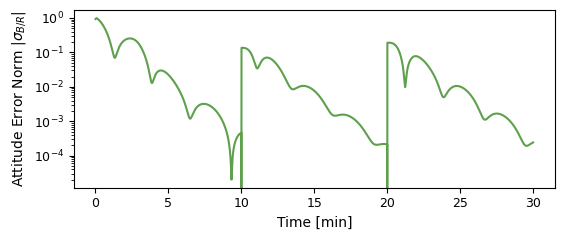

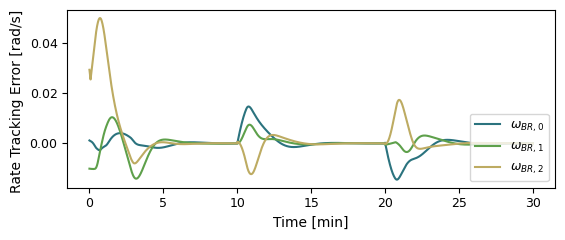

In [3]:

# Get current file path
import inspect
import os
import sys

import numpy as np
from Basilisk.utilities import orbitalMotion, macros

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.getcwd()

# Import master classes: simulation base class and scenario base class
sys.path.append(path + '/../')
sys.path.append(path + '/../models')
sys.path.append(path + '/../plotting')
from sim_masters import Sim, Scenario
import cubesat_dynamics, cubesat_fsw
import cubesat_plotting as plots


# Create your own scenario child class
class scenario_AttModes(Sim, Scenario):
    def __init__(self):
        super(scenario_AttModes, self).__init__()
        self.name = 'scenario_AttModes'

        # declare additional class variables
        self.msgRecList = {}
        self.sNavTransName = "sNavTransMsg"
        self.attGuidName = "attGuidMsg"

        self.set_DynModel(cubesat_dynamics)
        self.set_FswModel(cubesat_fsw)

        self.configure_initial_conditions()
        self.log_outputs()

        # if this scenario is to interface with the BSK Viz, uncomment the following line
        DynModels = self.get_DynModel()
        # vizSupport.enableUnityVisualization(self, DynModels.taskName, DynModels.scObject
        #                                     # , saveFile=__file__
        #                                     , rwEffectorList=DynModels.rwStateEffector
        #                                     )

    def configure_initial_conditions(self):
        # Configure Dynamics initial conditions
        oe = orbitalMotion.ClassicElements()
        oe.a = 10000000.0  # meters
        oe.e = 0.01
        oe.i = 33.3 * macros.D2R
        oe.Omega = 48.2 * macros.D2R
        oe.omega = 347.8 * macros.D2R
        oe.f = 85.3 * macros.D2R

        DynModels = self.get_DynModel()
        mu = DynModels.gravFactory.gravBodies['earth'].mu
        rN, vN = orbitalMotion.elem2rv(mu, oe)
        orbitalMotion.rv2elem(mu, rN, vN)
        DynModels.scObject.hub.r_CN_NInit = rN  # m   - r_CN_N
        DynModels.scObject.hub.v_CN_NInit = vN  # m/s - v_CN_N
        DynModels.scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
        DynModels.scObject.hub.omega_BN_BInit = [[0.001], [-0.01], [0.03]]  # rad/s - omega_BN_B

    def log_outputs(self):
        FswModel = self.get_FswModel()
        DynModel = self.get_DynModel()
        samplingTime = FswModel.processTasksTimeStep

        self.msgRecList[self.attGuidName] = FswModel.attGuidMsg.recorder(samplingTime)
        self.AddModelToTask(DynModel.taskName, self.msgRecList[self.attGuidName])

        self.msgRecList[self.sNavTransName] = DynModel.simpleNavObject.transOutMsg.recorder(samplingTime)
        self.AddModelToTask(DynModel.taskName, self.msgRecList[self.sNavTransName])

        return

    def pull_outputs(self, showPlots):
        # FSW process outputs, remove first data point as it is before FSW is called
        attErrRec = self.msgRecList[self.attGuidName]

        sigma_BR = np.delete(attErrRec.sigma_BR, 0, 0)
        omega_BR_B = np.delete(attErrRec.omega_BR_B, 0, 0)

        # Plot results
        plots.clear_all_plots()
        timeData = np.delete(attErrRec.times(), 0, 0) * macros.NANO2MIN
        plots.plot_attitude_error(timeData, sigma_BR)
        plots.plot_rate_error(timeData, omega_BR_B)
        figureList = {}
        if showPlots:
            plots.show_all_plots()
        else:
            fileName = os.path.basename(os.path.splitext(__file__)[0])
            figureNames = ["attitudeErrorNorm", "rateError"]
            figureList = plots.save_all_plots(fileName, figureNames)

        return figureList


def runScenario(scenario):
    """method to initialize and execute the scenario"""
    simulationTime = macros.min2nano(30.)

    scenario.InitializeSimulation()

    attitudeModeTime = macros.min2nano(10.)
    attitudeMode = ["hillPoint", "inertial3D"]

    currentSimulationTime = 0
    while currentSimulationTime < simulationTime:

        # Configure alternating FSW mode
        scenario.modeRequest = attitudeMode[int((currentSimulationTime / attitudeModeTime) % len(attitudeMode))]

        # Add the attitude mode time to the current simulation time
        currentSimulationTime += attitudeModeTime

        # Run the simulation
        scenario.ConfigureStopTime(currentSimulationTime)
        scenario.ExecuteSimulation()

    return


def run(showPlots):
    """
        The scenarios can be run with the followings setups parameters:

        Args:
            showPlots (bool): Determines if the script should display plots

    """
    scenario = scenario_AttModes()
    runScenario(scenario)
    figureList = scenario.pull_outputs(showPlots)
    return figureList

if __name__ == "__main__":
    run(True)
